In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
import gmaps
from config import gkey

In [3]:
# import patient csv
patient_file = "coronavirusdataset/patient.csv"
patient_df = pd.read_csv(patient_file).set_index('id')
patient_df.head()

,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
id,,,,,,,,,,,,,
1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [4]:
# import route csv
route_file = "coronavirusdataset/route.csv"
route_df = pd.read_csv(route_file)
route_df.head()

,id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


In [5]:
# import time csv
time_file = "coronavirusdataset/time.csv"
time_df = pd.read_csv(time_file)
time_df.head()

,date,acc_test,acc_negative,acc_confirmed,acc_released,acc_deceased,new_test,new_negative,new_confirmed,new_released,new_deceased
0,2020-01-20,1,0,1,0,0,1,0,1,0,0
1,2020-01-21,1,0,1,0,0,0,0,0,0,0
2,2020-01-22,4,3,1,0,0,3,3,0,0,0
3,2020-01-23,22,21,1,0,0,18,18,0,0,0
4,2020-01-24,27,25,2,0,0,5,4,1,0,0


In [6]:
# rename column
patient_df = patient_df.rename(columns={"sex":"gender"
                  ,"state":"patient_status"})

In [7]:
time_df = time_df.rename(columns={"acc_test":"gender"
                  ,"acc_negative":"patient_status"
                    ,"acc_confirmed":"accumulated_confirmed"
                    ,"acc_released":"accumulated_released"
                    ,"acc_deceased":"accumulated_deceased"})

In [8]:
# define function for transformations 
def gender(x):
    if x == 'female':
        return "F"
    elif x == 'male':
        return "M"
    else:
        return x

def patient_status(x):
    if x == 'released':
        return 'R'
    elif x == 'isolated':
        return 'I'
    elif x == 'deceased':
        return 'D'
    else:
        return x

In [9]:
# apply functions
patient_df['gender'] = patient_df['gender'].apply(gender)
patient_df['patient_status']=patient_df['patient_status'].apply(patient_status)

In [10]:
# drop unnecessary column
patient_df = patient_df.drop(['group', 'infection_order'], axis=1)

In [11]:
# connect to postgres
rds_connection_string = "postgres:postgres@localhost:5433/Coronavirus"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [12]:
# Confirm tables
engine.table_names()

['patient', 'route', 'time']

In [12]:
# import patient
patient_df.to_sql(name='patient', con=engine, if_exists='replace',index_label='id')

In [13]:
# import route
route_df = route_df.rename(columns={"id":'patient_id'})
route_df.index.names = ['id']
route_df.to_sql(name='route', con=engine, if_exists='replace', index_label='id')

In [14]:
# import time
time_df.set_index("date")
time_df.to_sql('time',con = engine ,if_exists='replace',index=True)

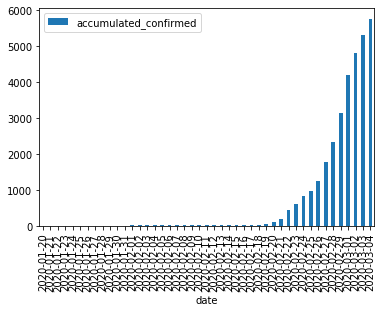

In [14]:
time_df.plot.bar(x='date', y='accumulated_confirmed')

In [15]:
gmaps.configure(api_key=gkey)

In [16]:
coordinates = route_df[["latitude", "longitude"]]

In [19]:
# Customize the size of the figure
figure_layout = {
    'width': '600px',
    'height': '500px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure(layout=figure_layout)

In [20]:
# Assign the marker layer to a variable
markers = gmaps.marker_layer(coordinates)
# Add the layer to the map
fig.add_layer(markers)
fig

Figure(layout=FigureLayout(border='1px solid black', height='500px', margin='0 auto 0 auto', padding='1px', wi…